In [55]:
#@title imports 
import os
import pickle
from typing import Set
# from jedi import settings
import matplotlib 
import numpy as np 
import matplotlib.pyplot as plt
from numpy.lib.function_base import append 
import scipy.io as spio
from scipy.io import loadmat, savemat
import importlib.util
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from scipy.sparse import data 
# from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
# from plotnine.data import mtcars
import pandas as pd 
import matplotlib as mpl 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap.plot as uplot
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import karate_club
import sys 
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import karate_club
from UMAP import *
pd.options.mode.use_inf_as_na = True

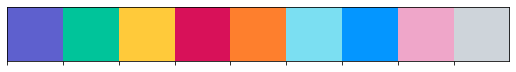

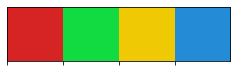

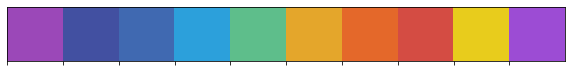

In [6]:

CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.609, 0.283, 0.724],
                    [0.259,	0.314, 0.635],
                    [0.251,	0.412, 0.698],
                    [0.176,	0.631, 0.859],
                    [0.369,	0.749, 0.549],
                    [0.898,	0.654, 0.169],
                    [0.898,	0.41 , 0.165],
                    [0.834,	0.3 , 0.265],
                    [0.912,	0.8 , 0.112],
                    [0.612,	0.3 , 0.834]]
sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

In [56]:
def plot_UMAP_clusters_single(data_inh, neighbours, distance, res_louvain, random_state, c_list ,save=False):
    """plots UMAP for excitatory and inhibitory cells 

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_umap_scaler = StandardScaler()
    data_umap = data_umap_scaler.fit_transform(data_inh)
    # data_umap = normalize(data_umap)
 
    neighbours = neighbours
    dist = distance
    reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)
    mapper = reducer.fit(data_umap)
    
    fig = plt.figure(figsize=[8,8])
    ax12d = fig.add_subplot(1,1,1)
    
    louvain = Louvain(resolution=res_louvain,random_state=random_state)
    adjacency = mapper.graph_
    labels_exc = louvain.fit_predict(adjacency)

    print(len(set(labels_exc)))
    clusterable_embedding2d_exc = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_umap)



    df_2d_exc = {'UMAP1':clusterable_embedding2d_exc[:, 0],
             'UMAP2':clusterable_embedding2d_exc[:, 1],
             'class':labels_exc}

    ax12d.set_xticks([])
    ax12d.set_yticks([])

    sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
    # sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',ax=ax12d)

    # ax12d.set_title('UMAP clusters for excitatory neurons 2D')
    ax12d.legend()
    if save:
        plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/exc_umap_cluster.png',dpi=200)
    
    plt.show()

    return labels_exc,mapper,reducer

In [57]:
pal = ["#00202e","#003f5c","#2c4875","#8a508f","#bc5090","#ff6361","#ff8531","#ffa600","#ffd380"]

In [58]:
waveforms = pickle.load(open('G:/My Drive/Cluster Feature files/waveforms.p','rb'))
waveforms_exc = np.array(waveforms['exc'])
waveforms_inh = np.array(waveforms['inh'])

In [10]:
waveform_combined = np.concatenate((waveforms_exc,waveforms_inh),axis=0)
df_waves = pd.DataFrame(columns=['waveforms','condition','exp_name'])
for i in range(len(waveform_combined)):
    df_waves.loc[i,'waveforms'] = np.array(waveform_combined[i,:169],dtype=np.float64)
    df_waves.loc[i,'condition'] = waveform_combined[i,170]
    df_waves.loc[i,'exp_name']  = waveform_combined[i,171]
df_waves_acsf = df_waves[df_waves.condition.isin(['aCSF','ACSF'])]

In [59]:
features_ext = ['AP_avg', 'dvdt_p','dvdt_n','avg_V','resistance','thr','adaptation','isi','peak',
                'peak_adaptation','ap_width', 'hyp_value','fist_spike','up_down_ratio','isi_adaptation',
                'thr_adp_ind','psth','int_fr','fr', 'sub_thr','mi','spk_fr_adp','imp','exp_name','cond' ]               
data_all_conds = pickle.load(open('G:/My Drive/Cluster Feature files/all_acsf_ephys_with_MI_new_res.p','rb'))
exc = data_all_conds['exc']
inh = data_all_conds['inh']
def return_resitance(data):
    return data[0]
def lower(data):
    return data.lower()
exc_df_all = pd.DataFrame(exc,columns = features_ext)
inh_df_all = pd.DataFrame(inh,columns = features_ext)
exc_df_all.resistance = exc_df_all.resistance.apply(return_resitance)
inh_df_all.resistance = inh_df_all.resistance.apply(return_resitance)
exc_inh_df = pd.concat([exc_df_all,inh_df_all])
exc_inh_df.index = np.arange(len(exc_inh_df))
inds =set(np.where(exc_inh_df.isna())[0])
print(len(inds),' cells discarded')
exc_inh_df_w_waves = pd.concat([exc_inh_df,df_waves['waveforms']],axis=1)
exc_inh_df_w_waves['ei_labels'] = np.concatenate((np.repeat(0,len(exc_df_all)),np.repeat(1,len(inh_df_all))))
exc_inh_df_w_waves = exc_inh_df_w_waves.drop(inds,axis=0)

exc_inh_df_w_waves.cond = exc_inh_df_w_waves.cond.apply(lower)    
exc_inh_df_w_waves_acsf = exc_inh_df_w_waves[exc_inh_df_w_waves.cond=='acsf'] 

38  cells discarded


0      1.140199
1      1.150000
2      1.172330
3      1.202757
4      1.328571
         ...   
575    1.425824
576    1.382452
577    1.778241
578    1.718868
579    1.821552
Name: ap_width, Length: 580, dtype: float64

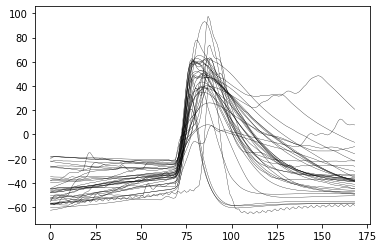

In [12]:
plt.plot(np.vstack(df_waves.loc[inds,:]['waveforms']).T,c='k',linewidth=0.3)
plt.show()

In [13]:
exc_inh_df_w_waves.columns

Index(['AP_avg', 'dvdt_p', 'dvdt_n', 'avg_V', 'resistance', 'thr',
       'adaptation', 'isi', 'peak', 'peak_adaptation', 'ap_width', 'hyp_value',
       'fist_spike', 'up_down_ratio', 'isi_adaptation', 'thr_adp_ind', 'psth',
       'int_fr', 'fr', 'sub_thr', 'mi', 'spk_fr_adp', 'imp', 'exp_name',
       'cond', 'waveforms', 'ei_labels'],
      dtype='object')

3


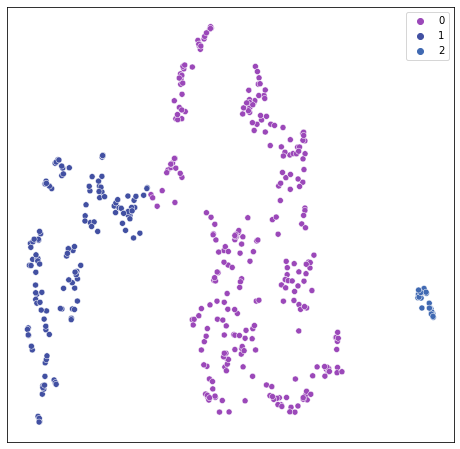

In [14]:
waves = normalize(np.vstack(exc_inh_df_w_waves_acsf['waveforms']))
labels_wave,mapper,reducer = plot_UMAP_clusters_single(waves,
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = 0.1,
                          c_list =coherence_colors,
                          )

In [15]:
exc_inh_df_w_waves_acsf['waveform_labels'] = labels_wave


<ipython-input-15-a1cf398cde64>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exc_inh_df_w_waves_acsf['waveform_labels'] = labels_wave


In [16]:
labels_set = set(labels_wave)
labels_dict = {}
for i,j in zip(GMM_PAL,labels_set):
    labels_dict[j] = i
labels_dict
a = [0,2,3,5]
a[0] = labels_dict[0]

UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

<Axes: >

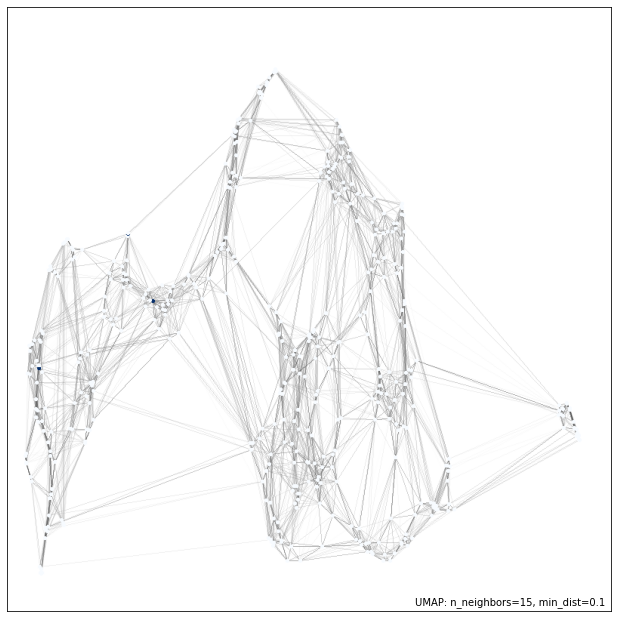

In [17]:
uplot.connectivity(mapper,cmap='BrBG_r',theme='blue',show_points=True)
# umap.plot.connectivity(mapper, edge_bundling='hammer')



0.0

0.5

1.0

1.5

2.0

2.5

3.0

3.5

4.0

4.5

5.0


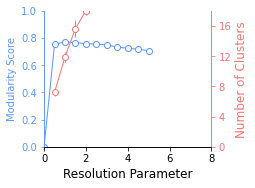

In [18]:
resolution_list = np.linspace(0,5,11)
modularity_dict = {}
n_clusts_dict = {}
#Louvain Clustering Parameters
RESOLUTION = 1.5
random_state = 42
full_data = df_waves_acsf['waveforms']
# BLUE COLOR
BlueCol = '\033[94m'
subsets=[100]
import random 
for res in resolution_list:
    print("\n" + BlueCol + str(res))
    for frac in subsets:
        rand_list = []
        n_clusts = []
        for i in list(range(1,25)):
            reducer_rand_test = umap.UMAP(n_neighbors = 20, 
                                     min_dist=0.0, 
                                     random_state=random.randint(1,100000))
            rand_data = np.vstack(np.random.permutation(full_data))
            mapper = reducer_rand_test.fit(rand_data)
            embedding_rand_test = reducer_rand_test.transform(rand_data)

            umap_df_rand_test = pd.DataFrame(embedding_rand_test, columns=('x', 'y'))
            louvain = Louvain(resolution=res,random_state=random_state)
            adjacency = mapper.graph_
            labels_exc = louvain.fit_predict(adjacency)
            clustering_solution = labels_exc
            modularity= get_modularity(adjacency,labels_exc)
            rand_list.append(modularity)
            n_clusts.append(len(set(clustering_solution)))
        modularity_dict.update({str(res): rand_list})
        n_clusts_dict.update({str(res): n_clusts})


resolution_list = np.linspace(0,5,11)

if 'n_clusts_dict' not in list(locals().keys()):
  n_clusts_dict = pkl.load(open('WaveMAP_Paper/data/n_clusts_dict.pkl','rb'))

if 'modularity_dict' not in list(locals().keys()):
  modularity_dict = pkl.load(open('WaveMAP_Paper/data/modularity_dict.pkl','rb'))

avg_n_clusts = []
for k in list(n_clusts_dict.keys()):
    avg_n_clusts.append(np.mean(n_clusts_dict[k]))
    
std_n_clusts = []
for k in list(n_clusts_dict.keys()):
    std_n_clusts.append(np.std(n_clusts_dict[k]))
    
std_modularity = []
for k in list(modularity_dict.keys()):
    std_modularity.append(np.std(modularity_dict[k]))
    
avg_modularity = []
for k in list(modularity_dict.keys()):
    avg_modularity.append(np.mean(modularity_dict[k]))

f, ax1 = plt.subplots(figsize=[3,2.5])

ax1.errorbar(resolution_list,avg_modularity,yerr=std_modularity,
             c = '#5c95ff', marker='o', fillstyle='full', markerfacecolor='w', 
             linewidth=1, markeredgewidth=1)
ax1.set_ylabel('Modularity Score')
ax1.set_xlabel('Resolution Parameter',fontsize=12)
ax1.set_xlim([0,8])
ax1.set_xticks([0,2,4,6,8])
ax1.yaxis.label.set_color('#5c95ff')
ax1.tick_params(axis='y',colors='#5c95ff')
ax1.set_ylim(0,1.0)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
# ax1.set_yticklabels([0.0,'',0.2,'',0.4,'',0.6,'',0.8,'',1.0],fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_color('#f87575')
ax1.spines['left'].set_color('#5c95ff')

ax2 = ax1.twinx()
ax2.errorbar(resolution_list[1:],avg_n_clusts[1:],yerr=std_n_clusts[1:],
            c = '#f87575', marker='o', fillstyle='full', markerfacecolor='w', linewidth=1, markeredgewidth=1)
ax2.set_ylabel('Number of Clusters',fontsize=12,c='#f87575')
# ax2.spines['left'].set_color('b')
ax2.tick_params(axis='y',colors='#f87575')
ax2.set_ylim([0,18])
ax2.set_yticks([0,4,8,12,16]);
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('#f87575')
ax2.spines['left'].set_color('#5c95ff')

Plotting: 848 Waveforms


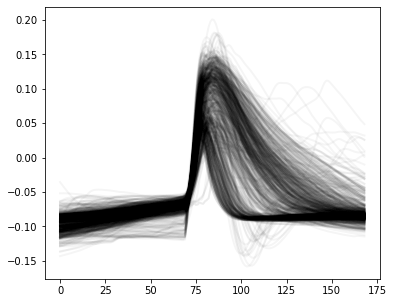

In [19]:
full_data = normalize(np.vstack(exc_inh_df_w_waves['waveforms']))
f, arr = plt.subplots(1,figsize=[6,5])

print( "Plotting: " + str(full_data.shape[0]) + " Waveforms")
for i in range(0,full_data.shape[0]):
    arr.plot(full_data[i], c = 'k', alpha = 0.04,linewidth=2.);    
plt.show()    

2


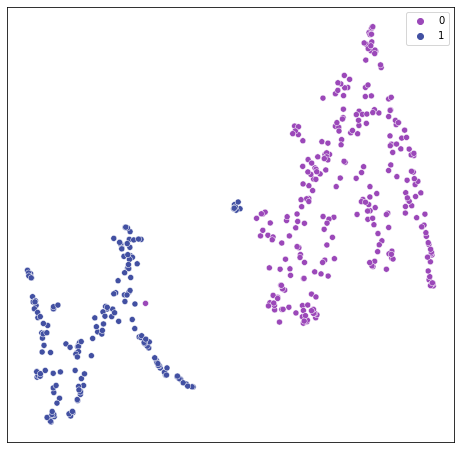

In [20]:
labels_wave_,mapper,reducer_ = plot_UMAP_clusters_single(np.vstack(exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf['waveform_labels']!=3]['waveforms']),
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 0.1,
                          c_list =coherence_colors,
                          )

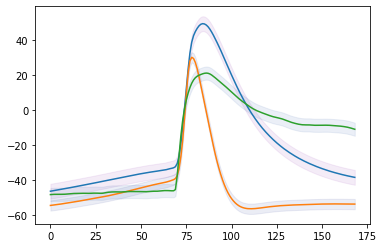

Plotting: 285 Waveforms


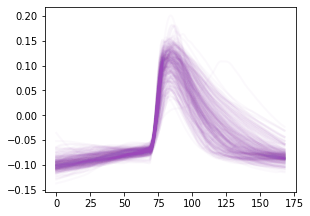

Plotting: 142 Waveforms


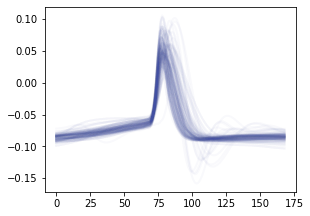

Plotting: 22 Waveforms


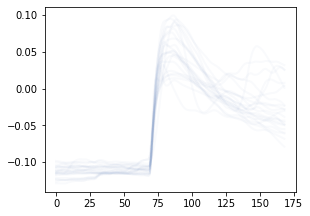

In [23]:
fig, ax = plt.subplots()

for i,j in zip(set(exc_inh_df_w_waves_acsf.waveform_labels),coherence_colors):
    x = np.arange(len(np.mean(exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf.waveform_labels==i]['waveforms'])))
    y = np.mean(exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf.waveform_labels==i]['waveforms'])
    #some confidence interval
    ci = 1.96 * np.std(y,axis=0)/np.sqrt(len(y))

    ax.plot(x,y)
    ax.fill_between(x, (y-ci), (y+ci), color=j, alpha=.1)

plt.show()

f, arr = plt.subplots(1,figsize=[4.5,3.4])

full_data = normalize(np.vstack(exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf.waveform_labels==0]['waveforms']))
print( "Plotting: " + str(full_data.shape[0]) + " Waveforms")
for i in range(0,full_data.shape[0]):
    arr.plot(full_data[i], c = coherence_colors[0], alpha = 0.03,linewidth=2.);
plt.show()

f, arr = plt.subplots(1,figsize=[4.5,3.4])

full_data = normalize(np.vstack(exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf.waveform_labels==1]['waveforms']))
print( "Plotting: " + str(full_data.shape[0]) + " Waveforms")
for i in range(0,full_data.shape[0]):
    arr.plot(full_data[i], c = coherence_colors[1], alpha = 0.03,linewidth=2.);
plt.show()

f, arr = plt.subplots(1,figsize=[4.5,3.4])
full_data = normalize(np.vstack(exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf.waveform_labels==2]['waveforms']))
print( "Plotting: " + str(full_data.shape[0]) + " Waveforms")
for i in range(0,full_data.shape[0]):
    arr.plot(full_data[i], c = coherence_colors[2], alpha = 0.03,linewidth=2.);    
plt.show()

# f, arr = plt.subplots(1,figsize=[4.5,3.4])
# full_data = normalize(np.vstack(exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf.waveform_labels==3]['waveforms']))
# print( "Plotting: " + str(full_data.shape[0]) + " Waveforms")
# for i in range(0,full_data.shape[0]):
#     arr.plot(full_data[i], c = coherence_colors[3], alpha = 0.03,linewidth=2.);    
# plt.show()

                

In [46]:
def join_wave_with_ephys(feat, df):
    return np.concatenate((df[feat[:-1]],normalize(np.vstack(df['waveforms']))),axis=1)
feat = ['AP_avg','ap_width','resistance','thr','isi', 'sub_thr', 'imp','waveforms']
# feat = exc_inh_df_w_waves_acsf.columns[:-5]
# exc_inh_df_w_waves_acsf = exc_inh_df_w_waves_acsf.drop_duplicates(subset='exp_name')
data = join_wave_with_ephys(feat,exc_inh_df_w_waves_acsf)
data_umap_scaler = StandardScaler()
data_umap = data_umap_scaler.fit_transform(data)
data_umap = normalize(data_umap)

neighbours = 20
dist = 0.0
random_state = 42
reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)
mapper = reducer.fit(data_umap)


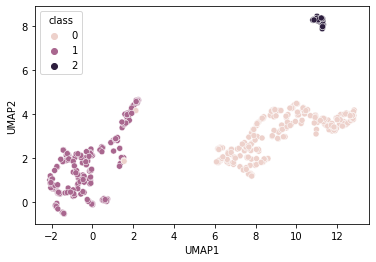

In [47]:
mods = []

# for res in np.arange(0.5,3.5,0.3):
res = 0.15
louvain = Louvain(resolution=res,random_state=random_state)
adjacency = mapper.graph_
labels_ephys = louvain.fit_predict(adjacency)
mods.append((res, get_modularity(adjacency,labels_ephys)))

clusterable_embedding2d_exc =reducer.fit_transform(data_umap)


df_2d_exc = {'UMAP1':clusterable_embedding2d_exc[:, 0],
        'UMAP2':clusterable_embedding2d_exc[:, 1],
        'class':labels_ephys}
sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class')
plt.show()

In [48]:
cells,features = data_umap.shape
pca = PCA(n_components=features)
scaler = StandardScaler()
data_all = data_umap
data_all = scaler.fit_transform(data_all)
data_all = normalize(data_all)
pca.fit(data_all)
eigenvalues = pca.explained_variance_
sum(eigenvalues)**2/sum(eigenvalues**2)

3.2027839603599966

In [53]:
# exc_inh_df_w_waves_acsf = exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf.waveform_labels!=2]
exc_inh_df_w_waves_acsf['ephys_labels'] = labels_ephys

<ipython-input-53-da20304073c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exc_inh_df_w_waves_acsf['ephys_labels'] = labels_ephys


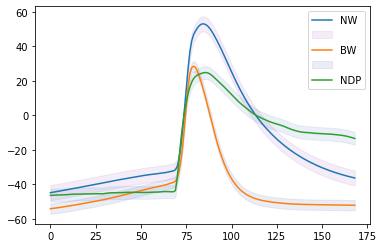

In [50]:
fig, ax = plt.subplots()

for i,j in zip(set(exc_inh_df_w_waves_acsf.ephys_labels),coherence_colors):
    x = np.arange(len(np.mean(exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf.ephys_labels==i]['waveforms'])))
    y = np.mean(exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf.ephys_labels==i]['waveforms'])
    #some confidence interval
    ci = 1.96 * np.std(y,axis=0)/np.sqrt(len(y))
    ax.plot(x,y,)
    ax.fill_between(x, (y-ci), (y+ci), color=j, alpha=.1)
ax.legend(['NW','','BW','','NDP'])    
plt.show()


In [54]:
inh_df_acsf = exc_inh_df_w_waves_acsf_12[exc_inh_df_w_waves_acsf['ephys_labels']==1]  
# inh_df_acsf = inh_df_acsf.drop_duplicates(subset='exp_name')

labels_inh,_,_ = plot_UMAP_clusters_single(join_wave_with_ephys(feat,exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf['ephys_labels']==1] ),
                          20,
                          0.0,
                          random_state =42,
                          res_louvain = 1.0,
                          c_list = coherence_colors,
                          )
inh_df_acsf['labels_lv'] = labels_inh


NameError: name 'exc_inh_df_w_waves_acsf_12' is not defined

In [51]:
sns.histplot(inh_df_acsf['labels_lv']+1,discrete=True)

NameError: name 'inh_df_acsf' is not defined

6


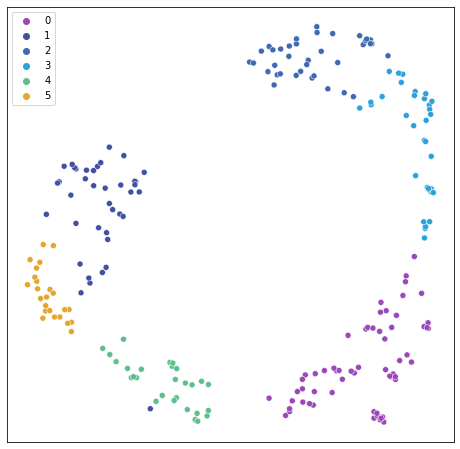

<ipython-input-507-a586e3fd522c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exc_df_acsf['labels_lv'] = labels_exc


In [507]:
exc_df_acsf =   exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf['ephys_labels']==0]
# exc_df_acsf = exc_df_acsf.drop_duplicates(subset='exp_name')

labels_exc,_,_ = plot_UMAP_clusters_single(join_wave_with_ephys(feat, exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf['ephys_labels']==0]),
                          20,
                          0.0,
                          random_state =42,
                          res_louvain = 1.0,
                          c_list = coherence_colors)
exc_df_acsf['labels_lv'] = labels_exc                

<Axes: xlabel='labels_lv', ylabel='Count'>

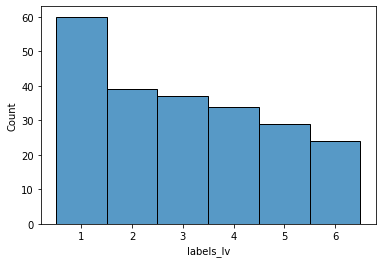

In [518]:
sns.histplot(exc_df_acsf['labels_lv']+1,discrete=True)


In [508]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(data,feat):
    
    testSize = 0.3;
    RAND_STATE = 20
    UMAP_X = np.stack(data[feat].to_numpy().tolist(), axis=0)
    UMAP_y = data['labels_lv'].to_numpy()

    unclassified_ixs = [ix for ix,clust in enumerate(UMAP_y) if clust == -1]

    UMAP_X = np.delete(UMAP_X,unclassified_ixs,axis=0)
    UMAP_y = np.delete(UMAP_y,unclassified_ixs,axis=0)

    UMAP_X_train, UMAP_X_test, UMAP_y_train, UMAP_y_test = train_test_split(UMAP_X, UMAP_y, test_size=testSize, random_state=RAND_STATE)


    numCV = 5

    UMAP_model = xgb.XGBClassifier()
    UMAP_param_dist = {"max_depth": [4],
                "min_child_weight" : [2.5],
                "n_estimators": [100],
                "learning_rate": [0.3],
                "seed": [RAND_STATE]}
    UMAP_grid_search = GridSearchCV(UMAP_model, param_grid=UMAP_param_dist, 
                            cv = numCV, 
                            verbose=10, n_jobs=-1)
    UMAP_grid_search.fit(UMAP_X_train, UMAP_y_train)

    return  confusion_matrix(UMAP_y_test,UMAP_grid_search.predict(UMAP_X_test))


Fitting 5 folds for each of 1 candidates, totalling 5 fits


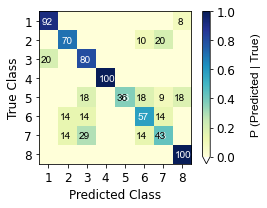

In [509]:
def plot_confusion_matrix(conf_matrix,labels):
    confusion_mat_counts = conf_matrix
    N_CLUST = len(set(labels))
    conf_mat_row_list = []
    for row in confusion_mat_counts:
        row_sum = np.sum(row)
        
        row_percent = []
        
        for val in row:
            row_percent.append(val/row_sum)
        
        conf_mat_row_list.append(row_percent)

    conf_mat = np.array(conf_mat_row_list)

    colormap = mpl.cm.YlGnBu
    colormap.set_under('white')

    eps = np.spacing(0.0)
    f, arr = plt.subplots(1,figsize=[4,3])
    mappable = arr.imshow(conf_mat,cmap=colormap,vmin=eps,vmax=1.)
    color_bar = f.colorbar(mappable, ax=arr, extend='min')
    color_bar.set_label('P (Predicted | True)',fontsize=12,labelpad=15,fontname="Arial")
    color_bar.ax.tick_params(size=3,labelsize=12)

    #Specify label behavior of the main diagonal
    for i in range(0,N_CLUST):
        if int(conf_mat[i,i]*100) == 100:
            arr.text(i-0.38,i+0.17,int(round(conf_mat[i,i]*100)),fontsize=10,c='white',fontname="Arial")
        else:
            arr.text(i-0.34,i+0.16,int(round(conf_mat[i,i]*100)),fontsize=10,c='white',fontname="Arial")
            
    #Specify label behavior of the off-diagonals
    for i in range(0,N_CLUST):
        for j in range(0,N_CLUST):
            if conf_mat[i,j] < 0.1 and conf_mat[i,j] != 0:
                arr.text(j-0.2,i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k',fontname="Arial")
            elif conf_mat[i,j] >= 0.1 and conf_mat[i,j] < 0.5 and conf_mat[i,j] != 0:
                arr.text(j-0.4, i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k',fontname="Arial")

    arr.set_xticks(range(0,N_CLUST))
    arr.set_xticklabels(range(1,N_CLUST+1),fontsize=12);
    arr.set_yticks(range(0,N_CLUST))
    arr.set_yticklabels(range(1,N_CLUST+1),fontsize=12);
    arr.set_xlabel('Predicted Class',fontsize=12);
    arr.set_ylabel('True Class',fontsize=12);
    plt.tight_layout()

plot_confusion_matrix(get_confusion_matrix(inh_df_acsf,feat[:-1]),labels_inh)    

<ipython-input-402-85aff6eda0ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exc_df_acsf['labels_lv'] = labels_exc


Fitting 5 folds for each of 1 candidates, totalling 5 fits


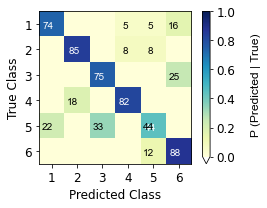

In [402]:
exc_df_acsf['labels_lv'] = labels_exc

plot_confusion_matrix(get_confusion_matrix(exc_df_acsf,feat[:-1]),labels_exc)    


0.0

0.5

1.0

1.5

2.0

2.5

3.0

3.5

4.0

4.5

5.0


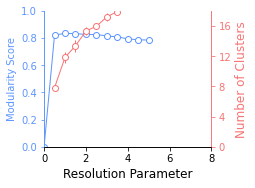

In [403]:
resolution_list = np.linspace(0,5,11)
modularity_dict = {}
n_clusts_dict = {}
#Louvain Clustering Parameters
RESOLUTION = 1.5
random_state = 42
full_data = join_wave_with_ephys(feat, exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf['ephys_labels']==0])
# BLUE COLOR
BlueCol = '\033[94m'
subsets=[100]
import random 
for res in resolution_list:
    print("\n" + BlueCol + str(res))
    for frac in subsets:
        rand_list = []
        n_clusts = []
        for i in list(range(1,25)):
            reducer_rand_test = umap.UMAP(n_neighbors = 20, 
                                     min_dist=0.0, 
                                     random_state=random.randint(1,100000))
            rand_data = np.random.permutation(full_data)[0:(int(len(full_data)*frac)),:]
            mapper = reducer_rand_test.fit(rand_data)
            embedding_rand_test = reducer_rand_test.transform(rand_data)

            umap_df_rand_test = pd.DataFrame(embedding_rand_test, columns=('x', 'y'))
            louvain = Louvain(resolution=res,random_state=random_state)
            adjacency = mapper.graph_
            labels_exc = louvain.fit_predict(adjacency)
            clustering_solution = labels_exc
            modularity= get_modularity(adjacency,labels_exc)
            rand_list.append(modularity)
            n_clusts.append(len(set(clustering_solution)))
        modularity_dict.update({str(res): rand_list})
        n_clusts_dict.update({str(res): n_clusts})


resolution_list = np.linspace(0,5,11)

if 'n_clusts_dict' not in list(locals().keys()):
  n_clusts_dict = pkl.load(open('WaveMAP_Paper/data/n_clusts_dict.pkl','rb'))

if 'modularity_dict' not in list(locals().keys()):
  modularity_dict = pkl.load(open('WaveMAP_Paper/data/modularity_dict.pkl','rb'))

avg_n_clusts = []
for k in list(n_clusts_dict.keys()):
    avg_n_clusts.append(np.mean(n_clusts_dict[k]))
    
std_n_clusts = []
for k in list(n_clusts_dict.keys()):
    std_n_clusts.append(np.std(n_clusts_dict[k]))
    
std_modularity = []
for k in list(modularity_dict.keys()):
    std_modularity.append(np.std(modularity_dict[k]))
    
avg_modularity = []
for k in list(modularity_dict.keys()):
    avg_modularity.append(np.mean(modularity_dict[k]))

f, ax1 = plt.subplots(figsize=[3,2.5])

ax1.errorbar(resolution_list,avg_modularity,yerr=std_modularity,
             c = '#5c95ff', marker='o', fillstyle='full', markerfacecolor='w', 
             linewidth=1, markeredgewidth=1)
ax1.set_ylabel('Modularity Score')
ax1.set_xlabel('Resolution Parameter',fontsize=12)
ax1.set_xlim([0,8])
ax1.set_xticks([0,2,4,6,8])
ax1.yaxis.label.set_color('#5c95ff')
ax1.tick_params(axis='y',colors='#5c95ff')
ax1.set_ylim(0,1.0)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
# ax1.set_yticklabels([0.0,'',0.2,'',0.4,'',0.6,'',0.8,'',1.0],fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_color('#f87575')
ax1.spines['left'].set_color('#5c95ff')

ax2 = ax1.twinx()
ax2.errorbar(resolution_list[1:],avg_n_clusts[1:],yerr=std_n_clusts[1:],
            c = '#f87575', marker='o', fillstyle='full', markerfacecolor='w', linewidth=1, markeredgewidth=1)
ax2.set_ylabel('Number of Clusters',fontsize=12,c='#f87575')
# ax2.spines['left'].set_color('b')
ax2.tick_params(axis='y',colors='#f87575')
ax2.set_ylim([0,18])
ax2.set_yticks([0,4,8,12,16]);
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('#f87575')
ax2.spines['left'].set_color('#5c95ff')

In [ ]:
testSize = 0.3;

UMAP_X = np.stack(umap_df['waveform'].to_numpy().tolist(), axis=0)
UMAP_y = umap_df['color'].to_numpy()

unclassified_ixs = [ix for ix,clust in enumerate(UMAP_y) if clust == -1]

UMAP_X = np.delete(UMAP_X,unclassified_ixs,axis=0)
UMAP_y = np.delete(UMAP_y,unclassified_ixs,axis=0)

UMAP_X_train, UMAP_X_test, UMAP_y_train, UMAP_y_test = train_test_split(UMAP_X, UMAP_y, test_size=testSize, random_state=RAND)



In [419]:
resolution_list = np.linspace(0,5,11)
modularity_dict = {}
n_clusts_dict = {}
#Louvain Clustering Parameters
RESOLUTION = 1.5
random_state = 42
full_data = join_wave_with_ephys(feat, exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf['ephys_labels']==1])
# BLUE COLOR
BlueCol = '\033[94m'
subsets=[100]
import random 
for res in resolution_list:
    print("\n" + BlueCol + str(res))
    for frac in subsets:
        rand_list = []
        n_clusts = []
        for i in list(range(1,25)):
            reducer_rand_test = umap.UMAP(n_neighbors = 20, 
                                     min_dist=0.0, 
                                     random_state=random.randint(1,100000))
            rand_data = np.random.permutation(full_data)[0:(int(len(full_data)*frac)),:]
            mapper = reducer_rand_test.fit(rand_data)
            embedding_rand_test = reducer_rand_test.transform(rand_data)

            umap_df_rand_test = pd.DataFrame(embedding_rand_test, columns=('x', 'y'))
            louvain = Louvain(resolution=res,random_state=random_state)
            adjacency = mapper.graph_
            labels_exc = louvain.fit_predict(adjacency)
            clustering_solution = labels_exc
            modularity= get_modularity(adjacency,labels_exc)
            rand_list.append(modularity)
            n_clusts.append(len(set(clustering_solution)))
        modularity_dict.update({str(res): rand_list})
        n_clusts_dict.update({str(res): n_clusts})


resolution_list = np.linspace(0,5,11)

if 'n_clusts_dict' not in list(locals().keys()):
  n_clusts_dict = pkl.load(open('WaveMAP_Paper/data/n_clusts_dict.pkl','rb'))

if 'modularity_dict' not in list(locals().keys()):
  modularity_dict = pkl.load(open('WaveMAP_Paper/data/modularity_dict.pkl','rb'))

avg_n_clusts = []
for k in list(n_clusts_dict.keys()):
    avg_n_clusts.append(np.mean(n_clusts_dict[k]))
    
std_n_clusts = []
for k in list(n_clusts_dict.keys()):
    std_n_clusts.append(np.std(n_clusts_dict[k]))
    
std_modularity = []
for k in list(modularity_dict.keys()):
    std_modularity.append(np.std(modularity_dict[k]))
    
avg_modularity = []
for k in list(modularity_dict.keys()):
    avg_modularity.append(np.mean(modularity_dict[k]))




0.0



0.5

1.0

1.5

2.0

2.5

3.0

3.5

4.0

4.5

5.0


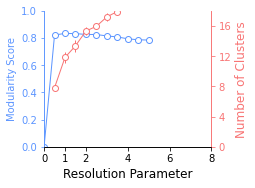

In [404]:
f, ax1 = plt.subplots(figsize=[3,2.5])

ax1.errorbar(resolution_list,avg_modularity,yerr=std_modularity,
             c = '#5c95ff', marker='o', fillstyle='full', markerfacecolor='w', 
             linewidth=1, markeredgewidth=1)
ax1.set_ylabel('Modularity Score')
ax1.set_xlabel('Resolution Parameter',fontsize=12)
ax1.set_xlim([0,8])
ax1.set_xticks([0,1,2,4,6,8])
ax1.yaxis.label.set_color('#5c95ff')
ax1.tick_params(axis='y',colors='#5c95ff')
ax1.set_ylim(0,1.0)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
# ax1.set_yticklabels([0.0,'',0.2,'',0.4,'',0.6,'',0.8,'',1.0],fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_color('#f87575')
ax1.spines['left'].set_color('#5c95ff')

ax2 = ax1.twinx()
ax2.errorbar(resolution_list[1:],avg_n_clusts[1:],yerr=std_n_clusts[1:],
            c = '#f87575', marker='o', fillstyle='full', markerfacecolor='w', linewidth=1, markeredgewidth=1)
ax2.set_ylabel('Number of Clusters',fontsize=12,c='#f87575')
# ax2.spines['left'].set_color('b')
ax2.tick_params(axis='y',colors='#f87575')
ax2.set_ylim([0,18])
ax2.set_yticks([0,4,8,12,16]);
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('#f87575')
ax2.spines['left'].set_color('#5c95ff')

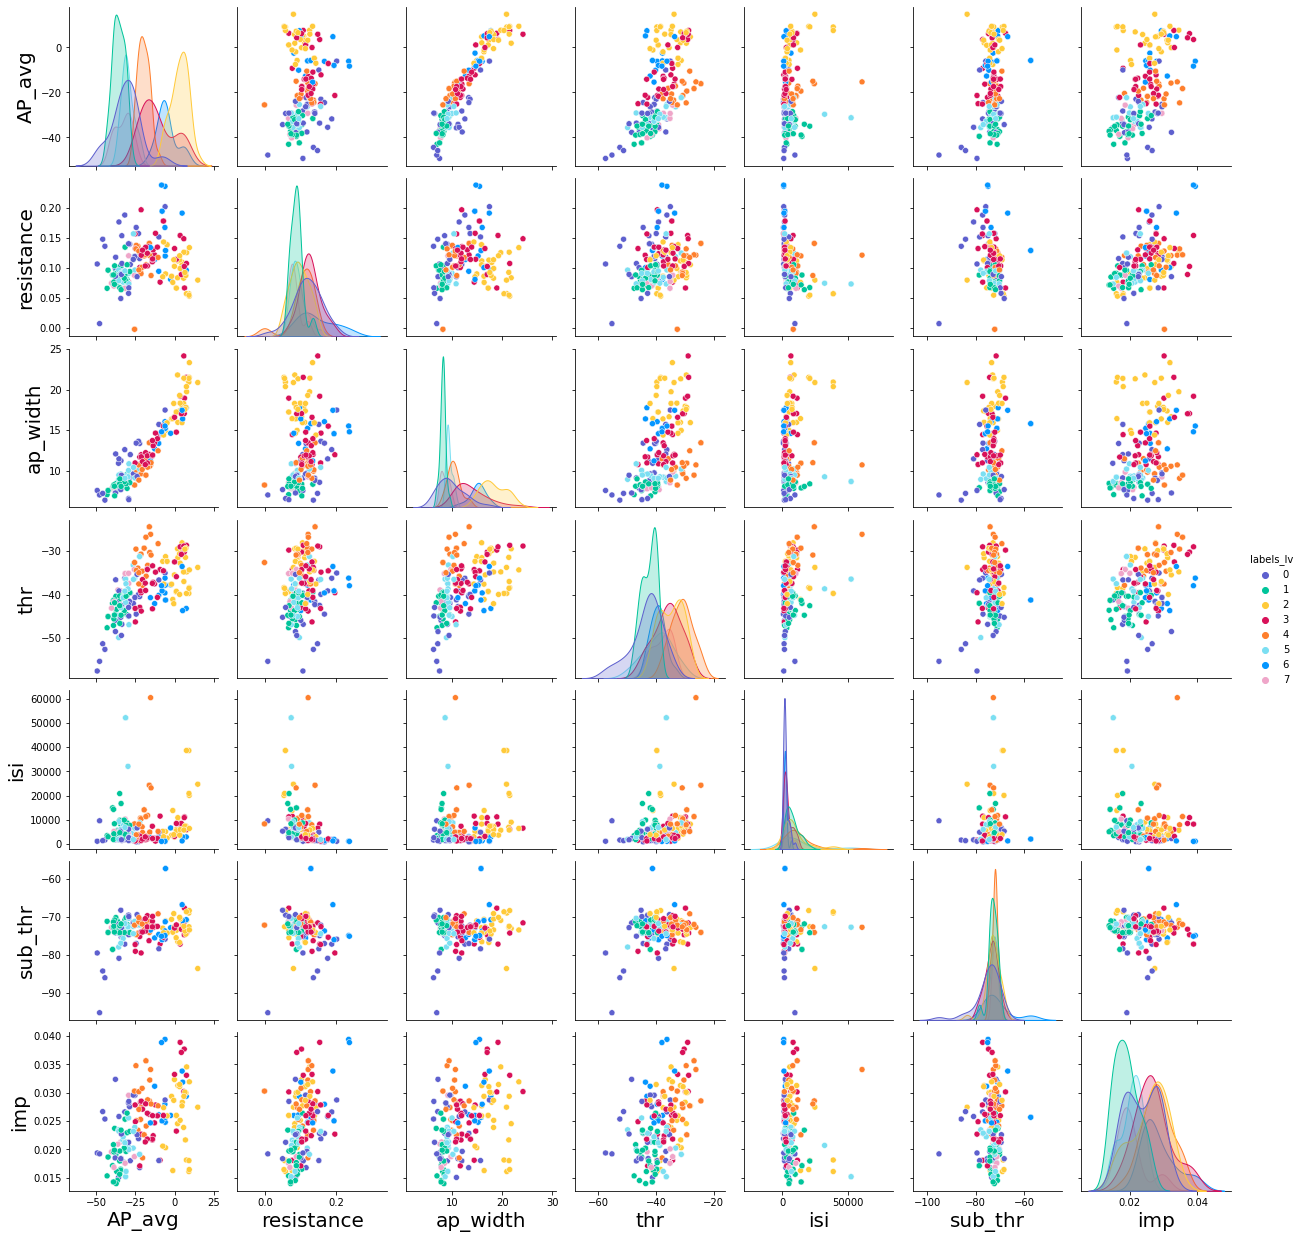

In [405]:
with sns.plotting_context(rc={"axes.labelsize":20}):
    sns.pairplot(inh_df_acsf[['AP_avg','resistance','ap_width','thr','isi', 'sub_thr', 'imp','labels_lv']],hue='labels_lv',palette=CUSTOM_PAL_SORT_3[:len(set(inh_df_acsf['labels_lv']))])


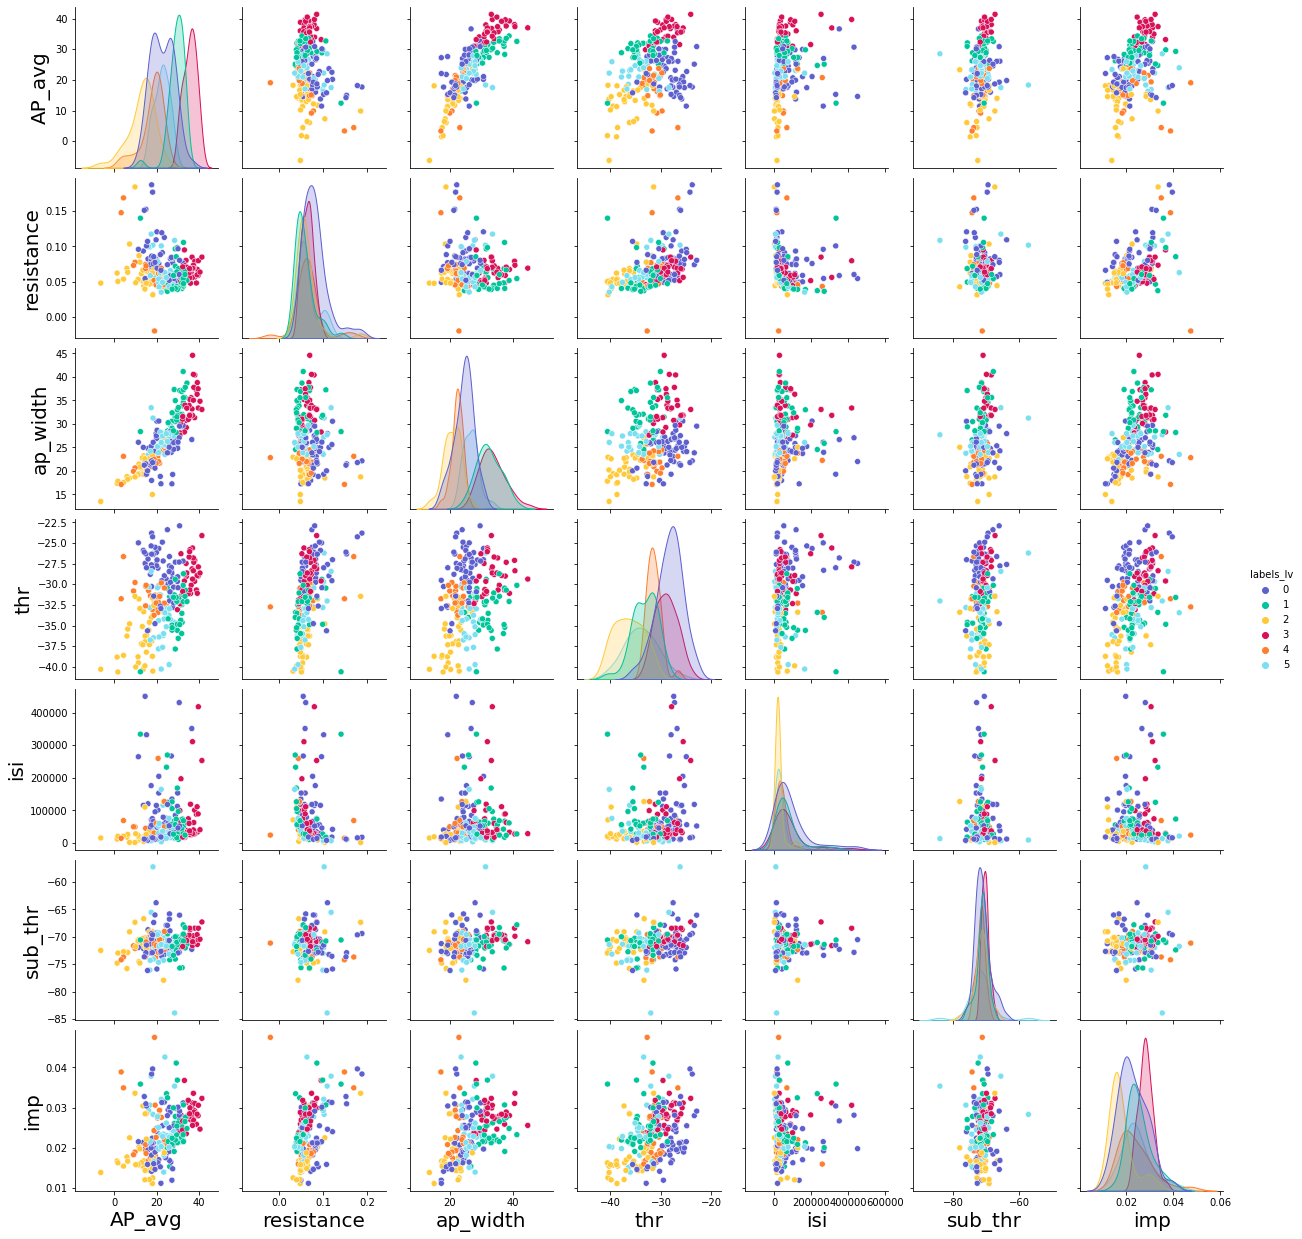

In [406]:
with sns.plotting_context(rc={"axes.labelsize":20}):
    sns.pairplot(exc_df_acsf[['AP_avg','resistance','ap_width','thr','isi', 'sub_thr', 'imp','labels_lv']],hue='labels_lv',palette=CUSTOM_PAL_SORT_3[:len(set(exc_df_acsf['labels_lv']))])


In [519]:
from scipy.stats import mannwhitneyu

def get_pvalues(data,var,hue):
    df = data
    x = hue
    y = var

    pairs = np.unique(data[hue])
    pairs = [i for i in combinations(pairs,2)]
    test_short_name = 'Mann-Whitney'
    pvalues = []
    sigs = []
    for pair in pairs:
        data1 = df.groupby(x)[y].get_group(pair[0])
        data2 = df.groupby(x)[y].get_group(pair[1])
        stat, p = mannwhitneyu(data1, data2)
        pvalues.append(p)

        if  p > 5.00e-02 and p <= 1.00e+00:
            sigs.append(0)
        elif 1.00e-02 < p and p <= 5.00e-02:
            sigs.append(1)
        elif 1.00e-03 < p and p<= 1.00e-02:
            sigs.append(2)
        elif 1.00e-04 < p and p<= 1.00e-03:
            sigs.append(3)   
        elif  p <= 1.00e-04:
            sigs.append(4)   

    sig_matrix = np.zeros((len(set(data.labels_lv)),len(set(data.labels_lv))))
    for i,j in enumerate(pairs):
        sig_matrix[j] = sigs[i]
    sig_matrix = sig_matrix+sig_matrix.T     
    return sig_matrix# pvalues,pairs,sigs


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:6.844e-13 U_stat=1.240e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.005e-03 U_stat=2.070e+02
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.636e-06 U_stat=6.500e+01
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:2.314e-02 U_stat=1.680e+02
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:2.811e-08 U_stat=4.600e+02
5 vs. 6: Mann-Whitney-Wilcoxon test two-sided, P_val:4.645e-01 U_stat=1.720e+02
6 vs. 7: Mann-Whitney-Wilcoxon test two-sided, P_val:3.331e-07 U_stat=0.000e+00
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.962e-11 U_stat=9.980e+02
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.775e-10 U_stat=0.000e+00
2 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:1.227e-06 U_stat=4.700e+01
3 vs. 5: Mann-Whitn

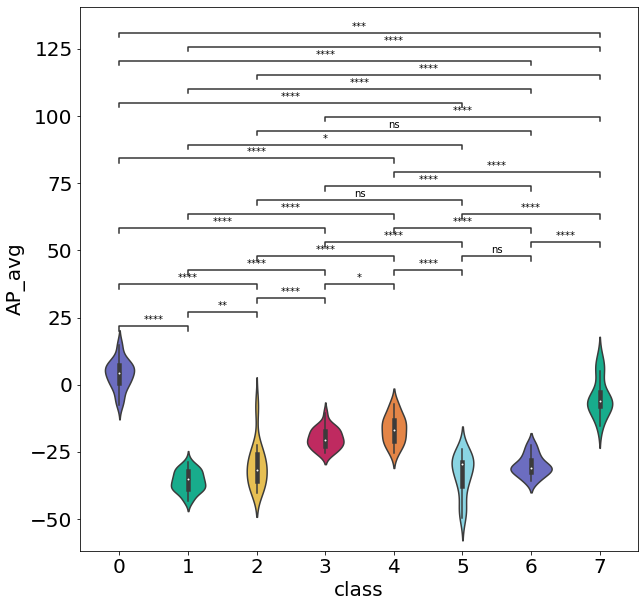

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:6.844e-13 U_stat=1.240e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.600e-04 U_stat=1.580e+02
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:6.003e-01 U_stat=2.850e+02
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:1.175e-05 U_stat=6.900e+01
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:2.126e-08 U_stat=4.620e+02
5 vs. 6: Mann-Whitney-Wilcoxon test two-sided, P_val:6.743e-03 U_stat=9.900e+01
6 vs. 7: Mann-Whitney-Wilcoxon test two-sided, P_val:3.331e-07 U_stat=0.000e+00
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.100e-10 U_stat=9.790e+02
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:7.201e-09 U_stat=3.600e+01
2 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:5.389e-03 U_stat=1.440e+02
3 vs. 5: Mann-Whitn

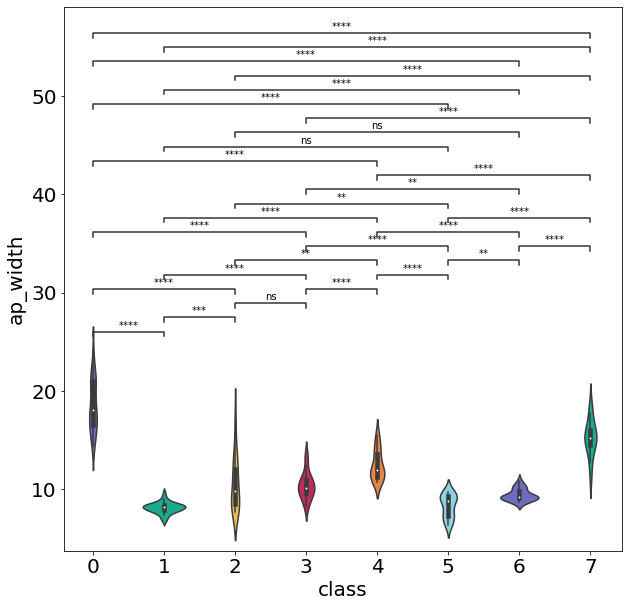

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.885e-02 U_stat=8.090e+02
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.043e-01 U_stat=3.100e+02
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:2.142e-01 U_stat=2.480e+02
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:2.447e-02 U_stat=1.690e+02
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:7.408e-02 U_stat=3.050e+02
5 vs. 6: Mann-Whitney-Wilcoxon test two-sided, P_val:1.040e-01 U_stat=2.600e+02
6 vs. 7: Mann-Whitney-Wilcoxon test two-sided, P_val:1.618e-04 U_stat=4.200e+01
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:9.516e-01 U_stat=4.950e+02
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.311e-04 U_stat=1.550e+02
2 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:1.151e-02 U_stat=1.560e+02
3 vs. 5: Mann-Whitn

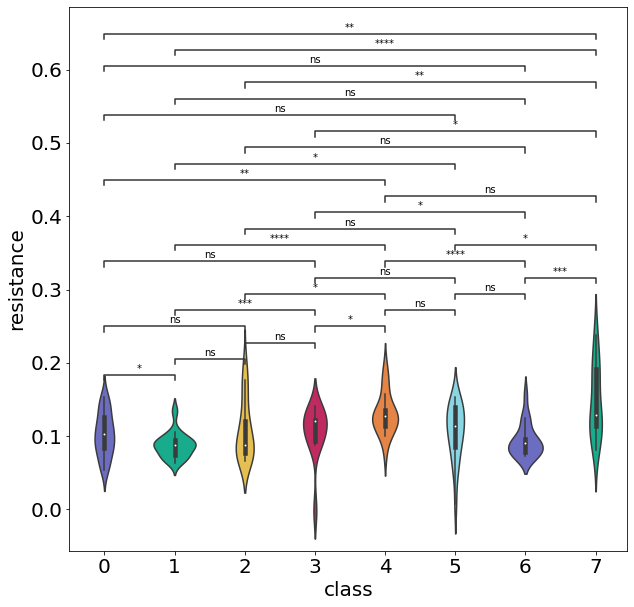

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:7.141e-02 U_stat=7.760e+02
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.217e-07 U_stat=7.700e+01
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:8.047e-06 U_stat=5.430e+02
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:3.898e-06 U_stat=5.800e+01
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:4.244e-02 U_stat=1.470e+02
5 vs. 6: Mann-Whitney-Wilcoxon test two-sided, P_val:6.815e-05 U_stat=3.470e+02
6 vs. 7: Mann-Whitney-Wilcoxon test two-sided, P_val:1.094e-03 U_stat=5.800e+01
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:9.465e-05 U_stat=2.100e+02
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:8.432e-01 U_stat=4.000e+02
2 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:9.066e-01 U_stat=2.810e+02
3 vs. 5: Mann-Whitn

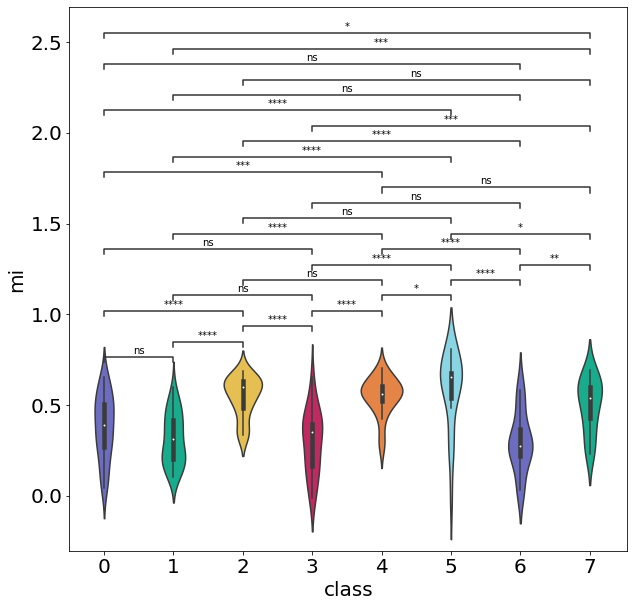

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.148e-11 U_stat=1.198e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.037e-05 U_stat=1.340e+02
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:9.433e-08 U_stat=3.700e+01
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:3.172e-06 U_stat=4.940e+02
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:6.401e-05 U_stat=3.960e+02
5 vs. 6: Mann-Whitney-Wilcoxon test two-sided, P_val:1.674e-03 U_stat=8.300e+01
6 vs. 7: Mann-Whitney-Wilcoxon test two-sided, P_val:8.492e-01 U_stat=1.680e+02
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.264e-05 U_stat=8.040e+02
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.775e-10 U_stat=0.000e+00
2 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:4.619e-01 U_stat=2.400e+02
3 vs. 5: Mann-Whitn

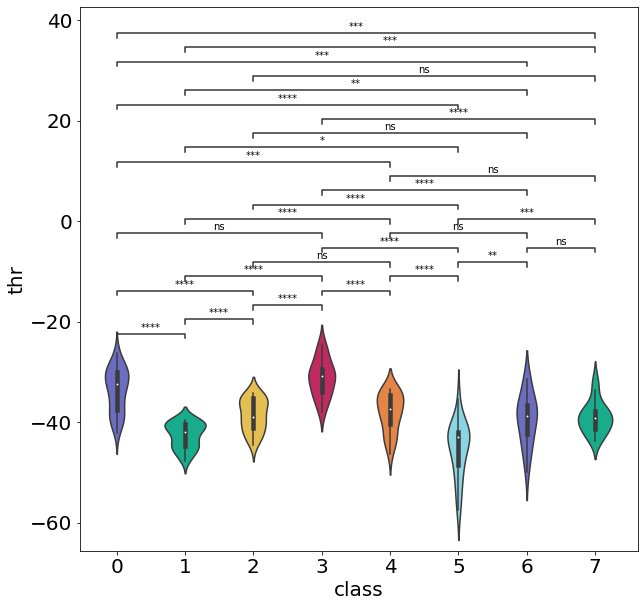

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.941e-01 U_stat=6.940e+02
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.384e-03 U_stat=5.820e+02
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:7.348e-06 U_stat=8.100e+01
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:7.950e-07 U_stat=5.070e+02
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:1.170e-01 U_stat=2.960e+02
5 vs. 6: Mann-Whitney-Wilcoxon test two-sided, P_val:1.863e-05 U_stat=4.100e+01
6 vs. 7: Mann-Whitney-Wilcoxon test two-sided, P_val:3.773e-05 U_stat=2.920e+02
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:8.858e-06 U_stat=8.300e+02
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:4.980e-02 U_stat=2.680e+02
2 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:2.188e-02 U_stat=3.830e+02
3 vs. 5: Mann-Whitn

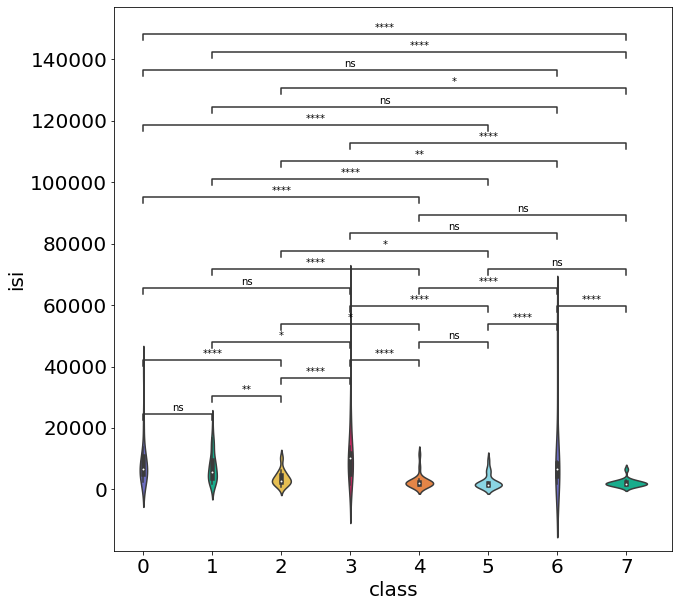

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:9.676e-01 U_stat=6.160e+02
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:7.169e-01 U_stat=4.100e+02
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:7.737e-02 U_stat=2.210e+02
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:2.731e-02 U_stat=3.790e+02
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:7.064e-01 U_stat=2.150e+02
5 vs. 6: Mann-Whitney-Wilcoxon test two-sided, P_val:6.845e-01 U_stat=1.840e+02
6 vs. 7: Mann-Whitney-Wilcoxon test two-sided, P_val:5.683e-01 U_stat=1.430e+02
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.908e-01 U_stat=5.300e+02
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.062e-01 U_stat=2.890e+02
2 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:6.314e-01 U_stat=2.980e+02
3 vs. 5: Mann-Whitn

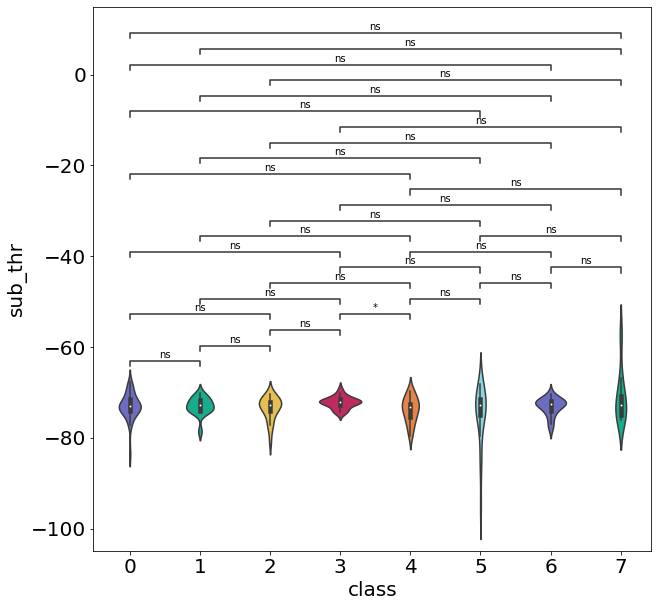

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.768e-08 U_stat=1.095e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.379e-01 U_stat=2.970e+02
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:4.641e-06 U_stat=7.600e+01
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:3.605e-03 U_stat=4.120e+02
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:4.156e-01 U_stat=1.970e+02
5 vs. 6: Mann-Whitney-Wilcoxon test two-sided, P_val:6.743e-03 U_stat=3.000e+02
6 vs. 7: Mann-Whitney-Wilcoxon test two-sided, P_val:7.608e-07 U_stat=5.000e+00
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.508e-05 U_stat=8.130e+02
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:2.292e-08 U_stat=4.800e+01
2 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:2.213e-03 U_stat=1.310e+02
3 vs. 5: Mann-Whitn

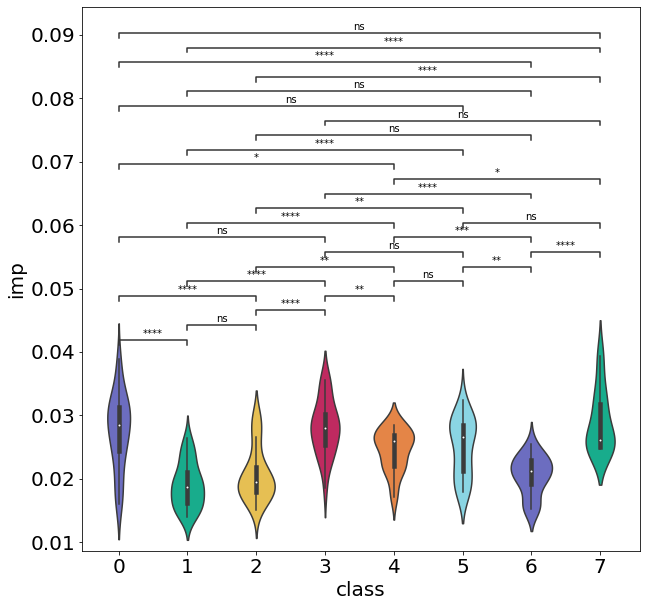

In [520]:
from itertools import combinations
from statannotations.Annotator import Annotator
def plot_significance_new(data,var,hue,ax,palette='mako',drug=False,test ='Mann-Whitney'):


    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    boxes = sns.violinplot(data=data,
                            x=hue,
                            y=var,
                            width=.6, 
                            palette=palette,
                            ax=ax)

    # sns.stripplot(x=hue, y=var , data=data,           
    #             size=3, color=".4", linewidth=0,ax=ax) 
    ax.set_xlabel('class',fontdict={'fontsize':20})
    ax.set_ylabel(var,fontdict={'fontsize':20})

    for box,col in zip(boxes.patches,['blue','crimson','teal']):
        mybox1 = box

        # Change the appearance of that box
        if drug:
            mybox1.set_facecolor('white')
            mybox1.set_edgecolor(col)
        else:
            mybox1.set_facecolor(col)
            mybox1.set_edgecolor('black')

        mybox1.set_linewidth(3)

    pairs = np.unique(data[hue])
    pairs = [i for i in combinations(pairs,2)]

    annotator = Annotator(ax,pairs, data=data, x=hue,palette=palette, y=var)
    annotator.configure(test=test, text_format='star', loc='inside')
    annotator.apply_and_annotate()  
    plt.show()

for val in ['AP_avg','ap_width', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']:

    fig,ax = plt.subplots(1,1,figsize=[10,10])

    plot_significance_new(data = inh_df_acsf,
    var = val,
    hue = 'labels_lv',
    ax = ax,
    drug = False,
    palette = CUSTOM_PAL_SORT_3[:len(set(exc_df_acsf['labels_lv']))] )
    # plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/'+val+'_'+cond+'_dist.png',dpi=200)


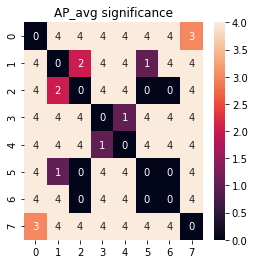

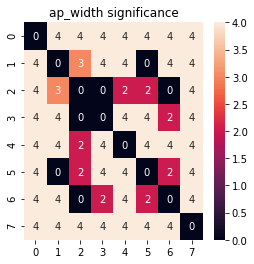

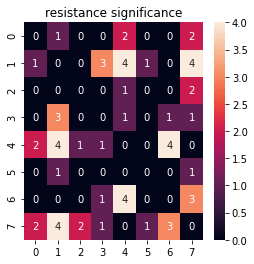

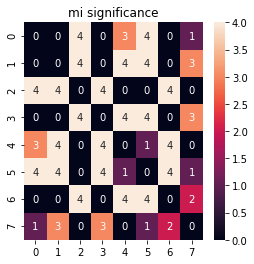

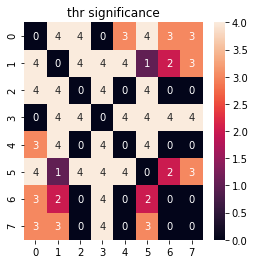

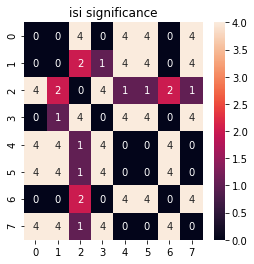

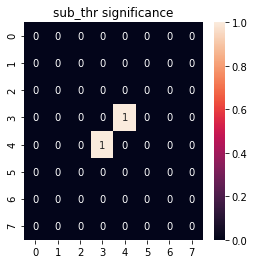

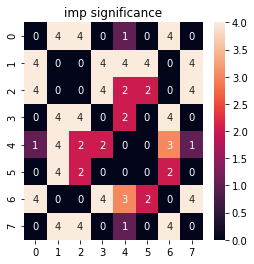

In [540]:
sig_all_inh = []
for val in ['AP_avg','ap_width', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']:    
    sig_matrix = get_pvalues(inh_df_acsf,var = val,hue = 'labels_lv',)
    sig_all_inh.append(sig_matrix)
    fig,ax = plt.subplots(1,1,figsize=[4,4])
    sns.heatmap(sig_matrix,annot=True,ax=ax)
    ax.set_title(val+' significance')
    plt.show()

<Axes: >

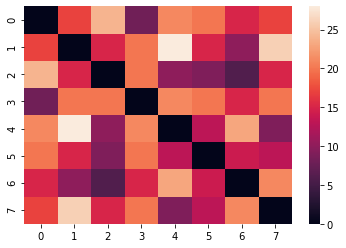

In [542]:
a_inh = np.zeros_like(sig_all_inh[0])
for i in np.arange(len(sig_all_inh)):
    a_inh += sig_all_inh[i]
sns.heatmap(a_inh)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.367e-09 U_stat=3.290e+02
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.900e-12 U_stat=1.273e+03
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:9.649e-13 U_stat=0.000e+00
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:1.109e-11 U_stat=9.860e+02
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:6.985e-04 U_stat=2.020e+02
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.442e-10 U_stat=1.939e+03
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:7.641e-10 U_stat=9.400e+01
2 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:1.147e-04 U_stat=2.210e+02
3 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:1.109e-11 U_stat=9.860e+02
0 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:4.479e-15 U_stat=3.000e+01
1 vs. 4: Mann-Whitn

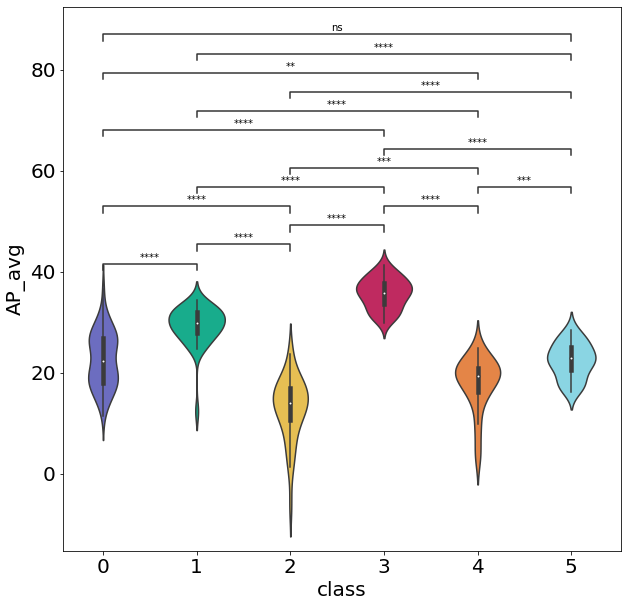

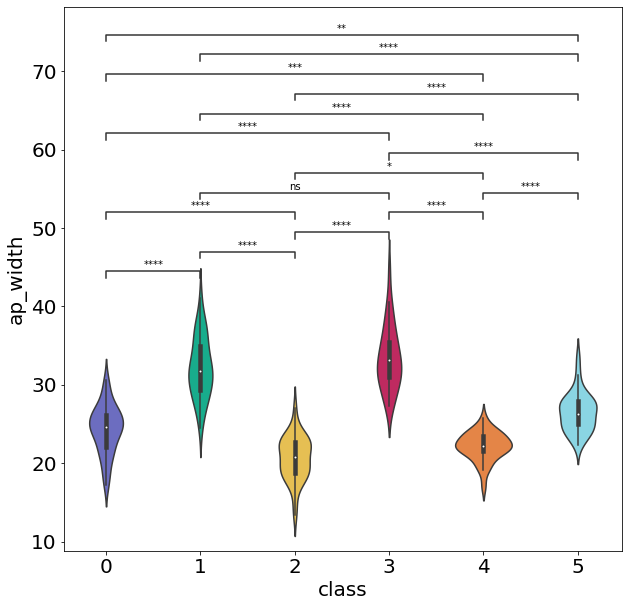

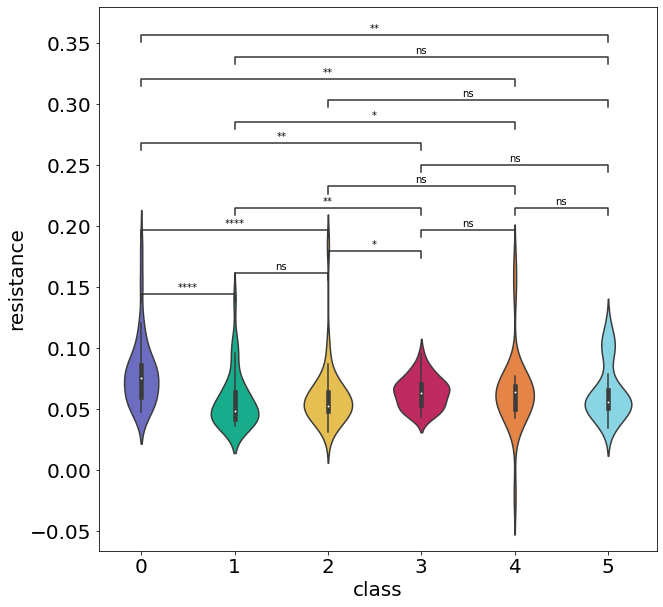

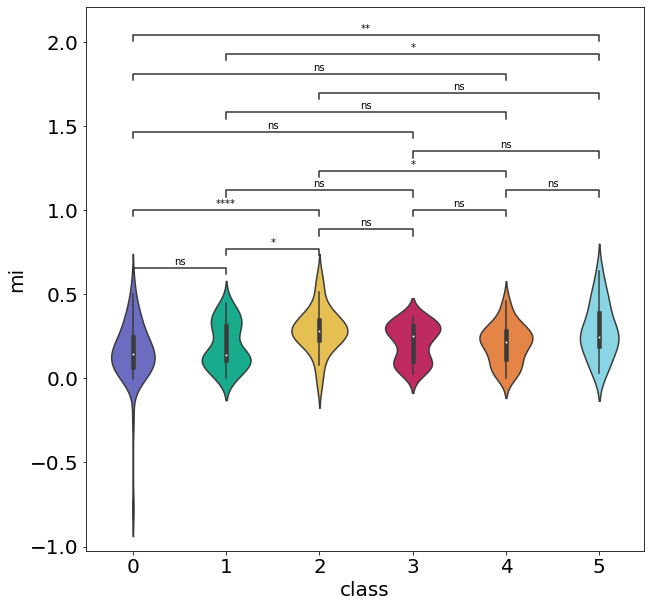

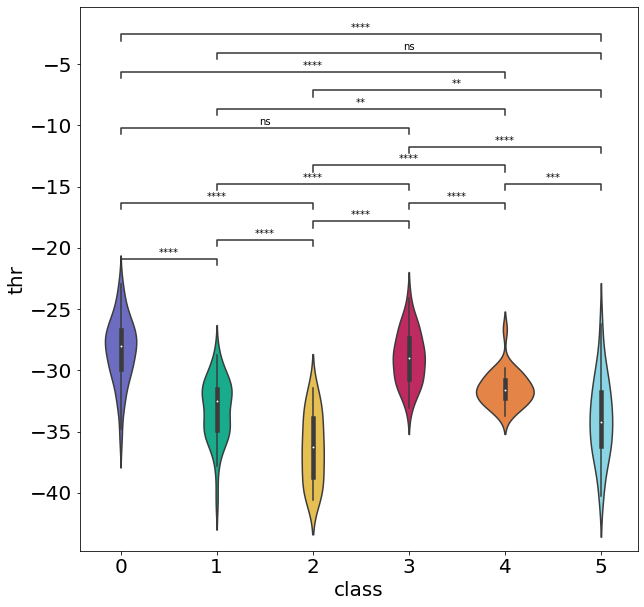

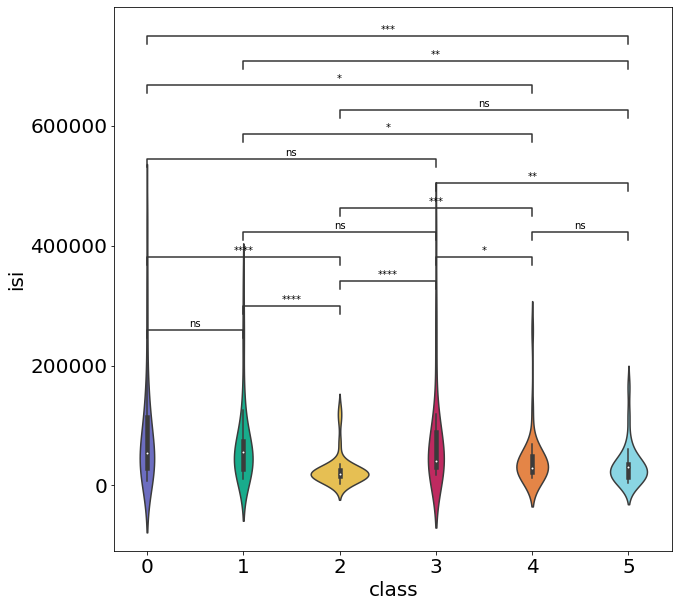

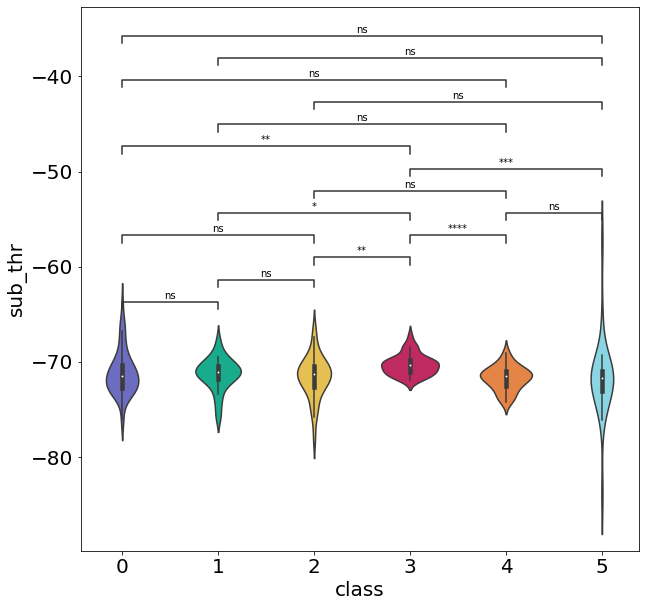

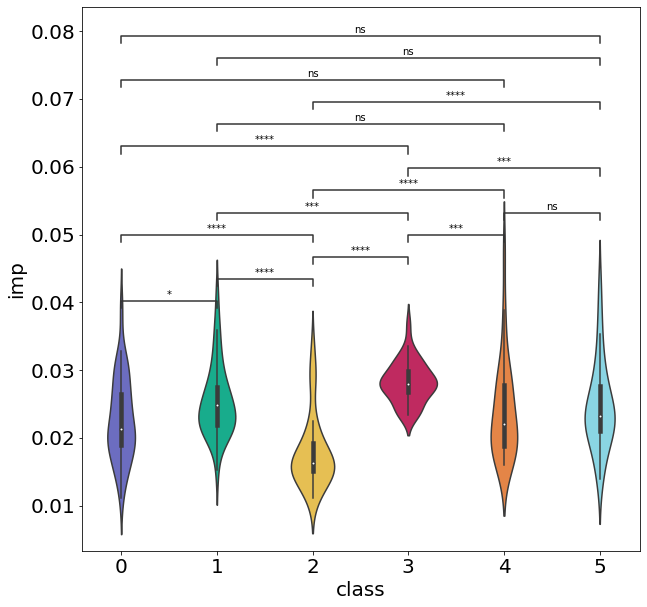

In [409]:
from itertools import combinations
from statannotations.Annotator import Annotator

def plot_significance_new(data,var,hue,ax,palette='mako',drug=False,test ='Mann-Whitney'):
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    boxes = sns.violinplot(data=data,
                x=hue,
                y=var,
                width=.6, 
                palette=palette,
                ax=ax)
                          
    # sns.stripplot(x=hue, y=var , data=data,
    #             size=3, color=".4", linewidth=0,ax=ax)
    ax.set_xlabel('class',fontdict={'fontsize':20})
    ax.set_ylabel(var,fontdict={'fontsize':20})

    for box,col in zip(boxes.patches,['blue','crimson','teal']):
        mybox1 = box

        # Change the appearance of that box
        if drug:
            mybox1.set_facecolor('white')
            mybox1.set_edgecolor(col)
        else:
            mybox1.set_facecolor(col)
            mybox1.set_edgecolor('black')

        mybox1.set_linewidth(3)

    pairs = np.unique(data[hue])
    pairs = [i for i in combinations(pairs,2)]


    annotator = Annotator(ax,pairs, data=data, x=hue,palette=palette, y=var)
    annotator.configure(test=test, text_format='star', loc='inside')
    annotator.apply_and_annotate()  

for val in ['AP_avg', 'ap_width','resistance','mi', 'thr', 'isi', 'sub_thr','imp']:
    fig,ax = plt.subplots(1,1,figsize=[10,10])
    plot_significance_new(data = exc_df_acsf,
    var = val,
    hue = 'labels_lv',
    ax = ax,
    drug = False,
    palette = CUSTOM_PAL_SORT_3[:len(set(exc_df_acsf['labels_lv']))])
    # plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/'+val+'_'+cond+'_dist.png',dpi=200)


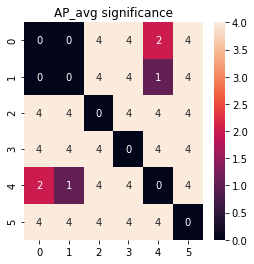

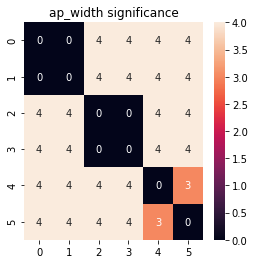

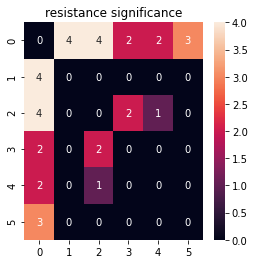

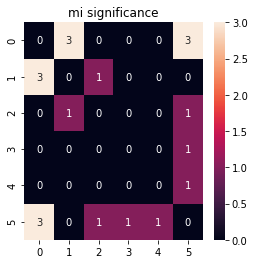

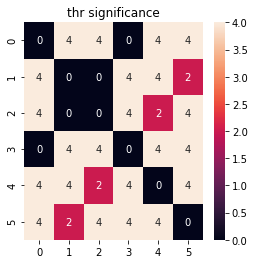

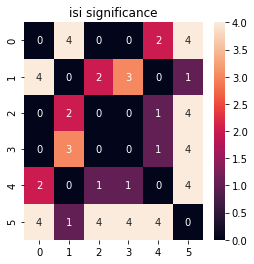

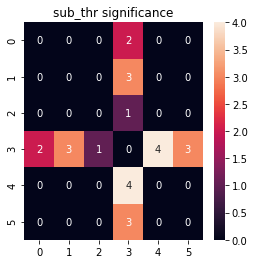

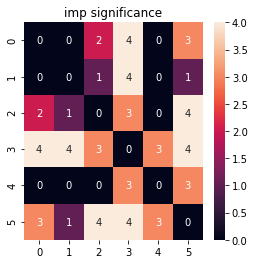

In [536]:
sig_all_exc = []
for val in ['AP_avg','ap_width', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']:    
    sig_matrix = get_pvalues(exc_df_acsf,var = val,hue = 'labels_lv',)
    sig_all_exc.append(sig_matrix)
    fig,ax = plt.subplots(1,1,figsize=[4,4])
    sns.heatmap(sig_matrix,annot=True,ax=ax)
    ax.set_title(val+' significance')
    plt.show()

<Axes: >

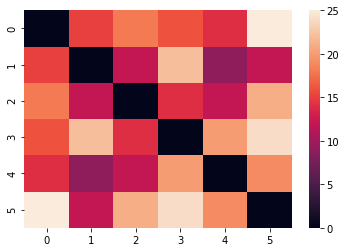

In [543]:
a_exc = np.zeros_like(sig_all[0])
for i in np.arange(len(sig_all)):
    a_exc += sig_all_exc[i]
sns.heatmap(a_exc)